In [550]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, text
import pymc as pm
import arviz as az
from scipy.stats import zscore

# Define the SQLalchemy engine
engine = create_engine(f"sqlite:////Users/JO/PhD/neuro-ascertainment/data/db.sqlite")

# Read the SQL query from the file
with open('/Users/JO/PhD/neuro-ascertainment/candidate-queries/transferred-nsicu-cohort/transferred-cohort.sql', 'r') as file:
    query = file.read()

SEED = 20
rng = np.random.default_rng(SEED)

def count_id(df):
    LopNr = df['LopNr'].nunique() if 'LopNr' in df else 'Column missing'
    VtfId_LopNr = df['VtfId_LopNr'].nunique() if 'VtfId_LopNr' in df else 'Column missing'
    HADM_ID = df['HADM_ID'].nunique() if 'HADM_ID' in df else 'Column missing'
    return print(f'Unique patients: {LopNr} | Unique SIR admits: {VtfId_LopNr} | Unique PAR admits: {HADM_ID}')

In [551]:
query_PAR_HADM = query + "SELECT * FROM PAR_HADM"
PAR_HADM = pd.read_sql(query_PAR_HADM, engine)
count_id(PAR_HADM)

Unique patients: 59333 | Unique SIR admits: Column missing | Unique PAR admits: 359305


In [552]:
query_PR_ICU_ADMISSIONS = query + "SELECT * FROM PR_ICU_ADMISSIONS"
PR_ICU_ADMISSIONS = pd.read_sql(query_PR_ICU_ADMISSIONS, engine)
count_id(PR_ICU_ADMISSIONS)

Unique patients: 26518 | Unique SIR admits: 28822 | Unique PAR admits: Column missing


In [553]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR)

Unique patients: 8120 | Unique SIR admits: 8272 | Unique PAR admits: 8667


In [554]:
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS
0,175633.0,186729,33694.0,1610590020,1610648400,STGIVA,18641,18668,331,11003
1,175640.0,203729,36615.0,1610658000,1610673300,SU/IVA-INF,18641,18642,121,51001
2,175646.0,276169,49700.0,1610711100,1610721000,Västerås,18642,18654,331,12001
3,175794.0,7766,1331.0,1610671860,1610676900,Eksjö-IVA,18642,18649,331,21001
4,175656.0,277574,49960.0,1610677800,1610693100,Karlstad-IVA,18642,18653,331,12001
...,...,...,...,...,...,...,...,...,...,...
8710,145010.0,123853,22301.0,1476271500,1476275340,Jönköping-IVA,17086,17098,331,21001
8711,145266.0,14926,2574.0,1476761520,1476765000,Kalmar,17092,17102,331,21001
8712,145013.0,163495,29576.0,1476966840,1476973800,Jönköping-IVA,17094,17120,331,21001
8713,145269.0,229144,41241.0,1477672200,1477674600,Kalmar,17102,17112,331,21001


In [555]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX)

Unique patients: 8120 | Unique SIR admits: 8272 | Unique PAR admits: 8667


In [556]:
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX.query("LopNr == 14801")

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS,DIAGNOS,OP,DX_GROUP,earliest_admit_date
2004,144094.0,83402,14801.0,1473263100,1473303600,Gävle,17051,17059,331,12001,S065 I639,AAA27 AAD05 AAK10 SB411,TBI,17051
2005,144136.0,83402,14801.0,1473246000,1473251100,Bollnäs,17051,17059,331,12001,S065 I639,AAA27 AAD05 AAK10 SB411,TBI,17051


In [557]:
query_TIME_HIERARCHY= query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY"
TIME_HIERARCHY  = pd.read_sql(query_TIME_HIERARCHY, engine)
count_id(TIME_HIERARCHY)

Unique patients: 7239 | Unique SIR admits: 7362 | Unique PAR admits: 7622


In [577]:
query_DESC_PAR = query + "SELECT * FROM SUMMARY_TABLE"
DESC = pd.read_sql(query_DESC_PAR, engine)


DESC['par_adm_date'] = pd.to_datetime(DESC['par_adm_date'], unit='D')
DESC['par_dsc_date'] = pd.to_datetime(DESC['par_dsc_date'], unit='D')
#DESC['earliest_admit_date'] = pd.to_datetime(DESC['earliest_admit_date'], unit='D')
DESC['earliest_par_admit_date'] = pd.to_datetime(DESC['earliest_par_admit_date'], unit='D')

DESC['sir_adm_time'] = pd.to_datetime(DESC['sir_adm_time'], unit='s').dt.normalize()
DESC['sir_dsc_time'] = pd.to_datetime(DESC['sir_dsc_time'], unit='s').dt.normalize()
DESC['sir_adm_year'] = DESC['sir_adm_time'].dt.year

In [578]:
count_id(DESC)

Unique patients: 7239 | Unique SIR admits: 7362 | Unique PAR admits: 7319


In [583]:
DESC[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].query("rows_per_patient > 1").tail(40)

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_admit_date,earliest_par_admit_date
6049,52929.0,2018-02-21,2018-02-21,2018-02-22,2018-03-10,Karlstad-IVA,Akademiska sjukhuset,HC,2,1,2018-01-08,2018-01-08
6069,53121.0,2018-03-14,2018-03-14,2018-03-14,2018-03-15,Kungälv,Sahlgrenska universitetssjukhuset,ABM,2,0,2018-03-14,2018-03-14
6070,53121.0,2018-03-14,2018-03-15,2018-03-14,2018-03-15,SU/IVA-INF,Sahlgrenska universitetssjukhuset,ABM,2,-1,2018-03-14,2018-03-14
6201,54354.0,2012-08-14,2012-08-14,2012-08-14,2012-08-31,IVA Falun,Akademiska sjukhuset,ASAH,2,0,2012-08-14,2012-08-14
6202,54354.0,2013-02-04,2013-02-04,2013-02-04,2013-02-20,IVA Falun,Akademiska sjukhuset,ASAH,2,0,2012-08-14,2012-08-14
6289,55438.0,2014-12-24,2014-12-24,2014-12-24,2015-01-21,Kungälv,Sahlgrenska universitetssjukhuset,ASAH,2,0,2014-12-24,2014-12-24
6290,55438.0,2017-01-16,2017-01-17,2017-01-17,2017-01-29,Kungälv,Sahlgrenska universitetssjukhuset,HC,2,0,2014-12-24,2014-12-24
6398,56504.0,2013-11-11,2013-11-11,2013-11-11,2013-11-19,Västerås,Akademiska sjukhuset,ASAH,2,0,2013-11-11,2013-11-11
6399,56504.0,2013-11-20,2013-11-20,2013-11-20,2013-11-26,Västerås,Akademiska sjukhuset,ABM,2,0,2013-11-11,2013-11-11
6527,57295.0,2015-05-15,2015-05-15,2015-05-16,2015-05-16,Västerås,"Karolinska universitetssjukhuset, Solna",AIS,2,1,2015-05-15,2015-05-16


In [561]:
DESC.query("sir_adm_year == 2018").query("sir_icu_name == 'IVA Hudiksvall'")[['sir_adm_time', 'sir_dsc_time', 'age', 'par_adm_date', 'DX_GROUP', 'par_tertiary_center', 'any_AMV', 'earliest_admit_date']].sort_values(by="sir_adm_time")

,sir_adm_time,sir_dsc_time,age,par_adm_date,DX_GROUP,par_tertiary_center,any_AMV,earliest_admit_date
3972,2018-01-03,2018-01-03,66.0,2018-01-03,ASAH,Akademiska sjukhuset,0,2018-01-03
2960,2018-02-02,2018-02-03,68.0,2018-02-03,SDH,Akademiska sjukhuset,0,2018-02-02
7176,2018-06-26,2018-06-26,58.0,2018-06-26,SDH,Akademiska sjukhuset,1,2018-06-26
2973,2018-07-10,2018-07-11,61.0,2018-07-11,ICH,Akademiska sjukhuset,1,2018-07-10
2713,2018-07-25,2018-07-25,19.0,2018-07-25,CVT,Akademiska sjukhuset,1,2018-07-25
5804,2018-10-07,2018-10-07,37.0,2018-10-07,CFX,Akademiska sjukhuset,0,2018-10-07
5793,2018-10-10,2018-10-10,63.0,2018-10-10,AIS,Akademiska sjukhuset,0,2018-10-10


In [562]:
s = DESC.groupby('DX_GROUP').agg({'age': 'mean', 'sex_female': 'mean', 'sir_total_time': 'median', 'SAPS_GCS': 'median', 'any_AMV': 'mean', 'd30': 'mean', 'VtfId_LopNr': 'count'})
s.rename(columns={'VtfId_LopNr': 'n'}).sort_values(by='n', ascending=False)

,age,sex_female,sir_total_time,SAPS_GCS,any_AMV,d30,n
DX_GROUP,,,,,,,
TBI,57.335432,0.265288,185.0,12.0,0.598921,0.128147,2224
ASAH,58.962921,0.628652,110.0,12.0,0.471910,0.164607,1780
ICH,58.440729,0.403495,135.0,10.0,0.653495,0.209726,1316
AIS,64.207849,0.350291,115.0,13.0,0.406977,0.267442,688
SDH,67.749392,0.282238,162.0,11.0,0.377129,0.109489,411
ABM,54.758621,0.445623,355.0,11.0,0.647215,0.108753,377
CFX,57.400735,0.220588,402.5,15.0,0.257353,0.073529,272
TUM,49.395833,0.395833,142.5,7.0,0.489583,0.156250,96
SEP,57.333333,0.400000,725.0,6.5,0.400000,0.016667,60


In [563]:
with open('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/0-database-query/primary-based-transfer-query.sql', 'r') as file:
    old_query = file.read()
OLD_DESC = pd.read_sql(old_query, engine)

OLD_DESC['par_adm_date'] = pd.to_datetime(OLD_DESC['par_adm_date'], unit='D')
OLD_DESC['par_dsc_date'] = pd.to_datetime(OLD_DESC['par_dsc_date'], unit='D')
OLD_DESC['sir_adm_time'] = pd.to_datetime(OLD_DESC['sir_adm_time'], unit='s').dt.normalize()


In [564]:
count_id(DESC)

Unique patients: 7239 | Unique SIR admits: 7362 | Unique PAR admits: 7319


In [565]:
DESC[['LopNr', 'VtfId_LopNr', 'HADM_ID', 'sir_icu_name', 'par_tertiary_center', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'DX_GROUP', 'rows_per_patient']].query('rows_per_patient > 1').head(40)

,LopNr,VtfId_LopNr,HADM_ID,sir_icu_name,par_tertiary_center,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,DX_GROUP,rows_per_patient
4,27.0,140834.0,142,Sunderby,Norrlands universitetssjukhus,2016-02-11,2016-02-11,2016-02-12,2016-03-07,TBI,2
5,27.0,141382.0,144,Sunderby,Norrlands universitetssjukhus,2016-03-07,2016-03-07,2016-03-08,2016-03-13,TBI,2
9,102.0,159620.0,530,Nyköping,Akademiska sjukhuset,2018-10-15,2018-10-16,2018-10-16,2018-10-22,TBI,2
10,102.0,176394.0,534,Nyköping,Akademiska sjukhuset,2021-02-22,2021-02-22,2021-02-22,2021-02-28,TBI,2
80,911.0,143326.0,5276,Nyköping,Akademiska sjukhuset,2016-07-18,2016-07-18,2016-07-18,2016-07-22,TBI,2
81,911.0,143327.0,5278,Nyköping,Akademiska sjukhuset,2016-07-28,2016-07-28,2016-07-28,2016-08-05,TBI,2
158,1656.0,172234.0,9818,Kalmar,Universitetssjukhuset i Linköping,2020-07-01,2020-07-01,2020-07-01,2020-07-03,SDH,2
159,1656.0,172241.0,9821,Kalmar,Universitetssjukhuset i Linköping,2020-07-15,2020-07-15,2020-07-15,2020-07-17,SDH,2
179,1841.0,153691.0,10773,IVA Västervik,Universitetssjukhuset i Linköping,2018-01-13,2018-01-13,2018-01-13,2018-01-24,TBI,2
180,1841.0,174482.0,10782,IVA Västervik,Universitetssjukhuset i Linköping,2020-11-15,2020-11-15,2020-11-15,2020-11-20,TBI,2


In [566]:
count_id(OLD_DESC)

Unique patients: 7219 | Unique SIR admits: 7219 | Unique PAR admits: 7219


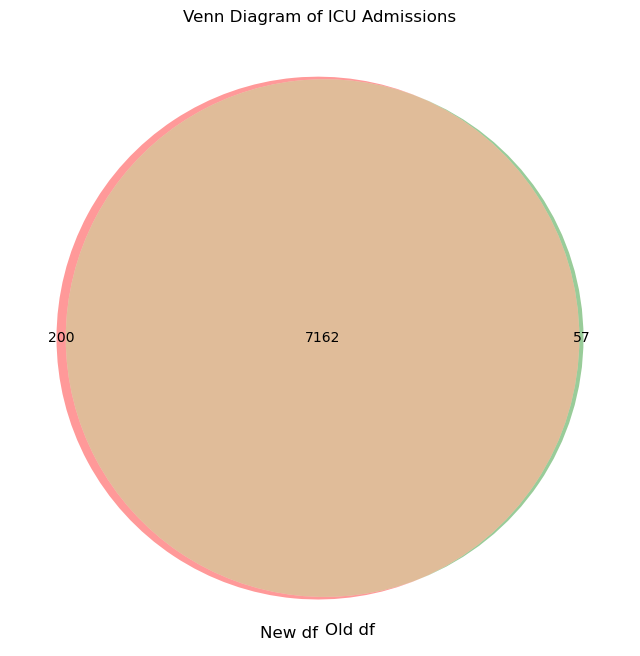

In [567]:
from matplotlib_venn import venn2

# Extract the unique IDs
set1 = set(DESC['VtfId_LopNr'])
set2 = set(OLD_DESC['VtfId_LopNr'])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2([set1, set2], ('New df', 'Old df'))
plt.title('Venn Diagram of ICU Admissions')
plt.show()

In [568]:
exclusive_to_new = set1 - set2
exclusive_to_old = set2 - set1

In [569]:
exclusive_new = DESC[DESC['VtfId_LopNr'].isin(exclusive_to_new)]

In [570]:
exclusive_new[['LopNr', 'VtfId_LopNr', 'HADM_ID', 'sir_icu_name', 'par_tertiary_center', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'DX_GROUP']]

,LopNr,VtfId_LopNr,HADM_ID,sir_icu_name,par_tertiary_center,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,DX_GROUP
5,27.0,141382.0,144,Sunderby,Norrlands universitetssjukhus,2016-03-07,2016-03-07,2016-03-08,2016-03-13,TBI
10,102.0,176394.0,534,Nyköping,Akademiska sjukhuset,2021-02-22,2021-02-22,2021-02-22,2021-02-28,TBI
46,495.0,145901.0,2542,SU/IVA-MS,Sahlgrenska universitetssjukhuset,2016-12-08,2016-12-08,2016-12-08,2016-12-09,TUM
81,911.0,143327.0,5278,Nyköping,Akademiska sjukhuset,2016-07-28,2016-07-28,2016-07-28,2016-08-05,TBI
132,1370.0,130986.0,8013,Karlstad-IVA,Sahlgrenska universitetssjukhuset,2014-10-03,2014-10-03,2014-10-03,2014-10-07,HC
...,...,...,...,...,...,...,...,...,...,...
7201,63272.0,173269.0,352286,IVA Falun,Akademiska sjukhuset,2020-09-02,2020-09-02,2020-09-02,2020-09-05,TBI
7238,63543.0,150695.0,353709,IVA Kristianstad,Universitetssjukhuset i Lund,2017-08-19,2017-08-19,2017-08-19,2017-08-19,TBI
7311,64071.0,168110.0,356563,Örnsköldsvik IVA,Norrlands universitetssjukhus,2019-12-15,2019-12-15,2019-12-16,2019-12-16,ICH
7332,64299.0,139137.0,357808,Västerås,Akademiska sjukhuset,2015-12-02,2015-12-02,2015-12-02,2015-12-04,TBI


In [571]:
exclusive_new.query("sir_icu_name == 'Karlstad-IVA'")[['LopNr', 'VtfId_LopNr', 'HADM_ID', 'sir_icu_name', 'par_tertiary_center', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'DX_GROUP']]

,LopNr,VtfId_LopNr,HADM_ID,sir_icu_name,par_tertiary_center,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,DX_GROUP
132,1370.0,130986.0,8013,Karlstad-IVA,Sahlgrenska universitetssjukhuset,2014-10-03,2014-10-03,2014-10-03,2014-10-07,HC
453,4264.0,114677.0,24239,Karlstad-IVA,Akademiska sjukhuset,2012-06-03,2012-06-03,2012-06-04,2012-06-20,ASAH
454,4264.0,114678.0,24239,Karlstad-IVA,Akademiska sjukhuset,2012-06-03,2012-06-04,2012-06-04,2012-06-20,ASAH
1175,10584.0,110760.0,60019,Karlstad-IVA,Akademiska sjukhuset,2011-10-27,2011-10-27,2011-10-27,2011-11-19,ASAH
1176,10584.0,139466.0,60024,Karlstad-IVA,Akademiska sjukhuset,2015-12-13,2015-12-14,2015-12-14,2015-12-23,ASAH
2476,21313.0,120239.0,118662,Karlstad-IVA,Akademiska sjukhuset,2013-03-14,2013-03-14,2013-03-14,2013-04-04,ABM
3146,27261.0,153561.0,150812,Karlstad-IVA,Akademiska sjukhuset,2017-12-22,2017-12-23,2017-12-23,2018-01-15,ABM
3508,31023.0,164657.0,172103,Karlstad-IVA,Akademiska sjukhuset,2019-07-04,2019-07-04,2019-07-04,2019-07-16,HC
3634,31922.0,142899.0,176643,Karlstad-IVA,Akademiska sjukhuset,2016-06-30,2016-07-01,2016-06-30,2016-07-08,ICH
4585,39948.0,138002.0,221651,Karlstad-IVA,Akademiska sjukhuset,2015-10-18,2015-10-19,2015-10-19,2015-11-24,ASAH


In [572]:
exclusive_old = OLD_DESC[OLD_DESC['VtfId_LopNr'].isin(exclusive_to_old)]

In [573]:
exclusive_old

,LopNr,HADM_ID,VtfId_LopNr,tertiary_center_id,par_adm_date,par_dsc_date,sir_icu_name,sir_hospital_type,sir_adm_time,sir_total_time,...,icu_discharge_month,icu_discharge_year,icu_admission_daytime,icu_admission_nighttime,icu_admission_afterhours,d7,d30,d90,d365,days_alive
201,2036.0,12008,134329.0,41001,2015-03-13,2015-03-15,IVA Kristianstad,Regional Hospital,2015-03-11,1280.0,...,03,2015,1,0,0,0,0,0,0,NaN
239,2368.0,13745,115939.0,51001,2012-07-25,2012-07-26,SU/IVA-ÖS,University Hospital,2012-07-26,618.0,...,07,2012,1,0,0,1,1,1,1,1.0
332,3264.0,18786,108504.0,51001,2011-07-13,2011-07-19,Borås-IVA,Regional Hospital,2011-07-11,1350.0,...,07,2011,0,1,1,0,0,0,0,556.0
390,3799.0,21711,127678.0,51001,2014-04-06,2014-04-17,Borås-IVA,Regional Hospital,2014-04-04,46.0,...,04,2014,0,1,1,0,0,0,0,NaN
517,4697.0,26432,153037.0,11001,2017-11-16,2017-11-18,SÖSIVA,Regional Hospital,2017-11-14,1266.0,...,11,2017,1,0,0,0,0,0,0,NaN
800,7234.0,41379,172331.0,51001,2020-07-22,2020-07-23,Skaraborg-IVA SIL,Community Hospital,2020-07-23,90.0,...,07,2020,0,0,1,0,0,0,0,NaN
978,8923.0,51401,163915.0,41001,2019-06-05,2019-06-17,IVA Kristianstad,Regional Hospital,2019-06-03,985.0,...,06,2019,0,1,1,0,0,0,0,419.0
993,9066.0,52184,113699.0,51001,2011-12-31,2012-01-02,SU/IVA-ÖS,University Hospital,2012-01-01,174.0,...,01,2012,0,1,1,0,0,0,0,NaN
1231,11347.0,64322,138590.0,12001,2015-10-27,2015-10-29,Sundsvall IVA,Regional Hospital,2015-10-25,1350.0,...,10,2015,0,0,1,0,0,0,0,NaN
1315,11958.0,67430,167660.0,11003,2019-11-21,2019-11-21,IVALBG,Community Hospital,2019-11-22,684.0,...,11,2019,0,1,1,1,1,1,1,2.0


In [574]:
exclusive_old.query("sir_icu_name == 'Borås-IVA'")

,LopNr,HADM_ID,VtfId_LopNr,tertiary_center_id,par_adm_date,par_dsc_date,sir_icu_name,sir_hospital_type,sir_adm_time,sir_total_time,...,icu_discharge_month,icu_discharge_year,icu_admission_daytime,icu_admission_nighttime,icu_admission_afterhours,d7,d30,d90,d365,days_alive
332,3264.0,18786,108504.0,51001,2011-07-13,2011-07-19,Borås-IVA,Regional Hospital,2011-07-11,1350.0,...,07,2011,0,1,1,0,0,0,0,556.0
390,3799.0,21711,127678.0,51001,2014-04-06,2014-04-17,Borås-IVA,Regional Hospital,2014-04-04,46.0,...,04,2014,0,1,1,0,0,0,0,NaN
1940,17506.0,98182,124230.0,51001,2013-09-30,2013-10-07,Borås-IVA,Regional Hospital,2013-09-28,765.0,...,09,2013,0,0,1,0,0,0,0,557.0
5497,49386.0,274703,116396.0,51001,2012-09-10,2012-09-16,Borås-IVA,Regional Hospital,2012-09-11,70.0,...,09,2012,1,0,0,0,0,0,0,NaN
7149,64009.0,356207,122801.0,51001,2013-08-16,2013-08-17,Borås-IVA,Regional Hospital,2013-08-17,200.0,...,08,2013,1,0,1,0,0,0,0,NaN
7193,64344.0,358035,121980.0,51001,2013-06-06,2013-06-07,Borås-IVA,Regional Hospital,2013-06-07,135.0,...,06,2013,0,0,1,0,0,0,0,NaN


In [575]:
test = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY"
df = pd.read_sql(test, engine)


df['INDATUM'] = pd.to_datetime(df['INDATUM'], unit='D')
df['UTDATUM'] = pd.to_datetime(df['UTDATUM'], unit='D')
df['InskrTidPunkt'] = pd.to_datetime(df['InskrTidPunkt'], unit='s').dt.normalize()
df['UtskrTidPunkt'] = pd.to_datetime(df['UtskrTidPunkt'], unit='s').dt.normalize()
df.query("LopNr == 49386.0")

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS,DIAGNOS,OP,DX_GROUP,earliest_admit_date,DX_ORDER


In [576]:
DESC.query("LopNr == 5881.0").sir_dsc_time

692   2020-03-18
693   2020-03-19
Name: sir_dsc_time, dtype: datetime64[ns]